In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/.conda/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

/home/akarsh_sakana_ai/.conda/envs/nca-alife-torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append(os.path.abspath(".."))
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [107]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=64, d_state=16, perception='fullconv', kernel_size=3,
    init_state="point", padding_mode="circular", dt=0.01, dropout=0.1, # changed dropout and initial state
    
    prompts="a biological cell;a single fat cat", spatial_scales="1.", clip_model="clip-vit-base-patch32",
    coef_alignment=1., coef_temporal_softmax=0.,
    
    rollout_steps=256, bptt_steps=16, pool_size=256, # changed the rollout steps and the pool size
    bs=8, lr=3e-4, n_iters=100000, clip_grad_norm=1.
)

seeds = np.arange(1)
prompts_sweep = [
    "a single biological cell,two biological cells",
    "a single biological cell,a big biological cell expanding,a biological cell undergoing cell division,two biological cells",
    "a biological cell,a cell splitting into two,multiple biological cells,a diverse ecosystem of cells",
    "a single bacterium under the microscope,two bacteria,four bacteria,eight bacteria",
]
coef_temporal_softmax_sweep = [0., 0.01, 0.03, 0.1, 0.3]

cfgs = []
for seed in seeds:
    for i1, prompts in enumerate(prompts_sweep):
        for coef_temporal_softmax in coef_temporal_softmax_sweep:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, prompts=prompts, coef_temporal_softmax=coef_temporal_softmax)
            cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_1/{seed}_{i1}_{coef_temporal_softmax}")
            cfgs.append(cfg)
    
print(len(cfgs))

20


In [4]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=64, d_state=16, perception='fullconv', kernel_size=3,
    init_state="circle_rand", padding_mode="circular", dt=0.01, dropout=0.1, # changed dropout and initial state
    
    prompts="a biological cell;a single fat cat", spatial_scales="1.", clip_model="clip-vit-base-patch32",
    coef_alignment=1., coef_temporal_softmax=0.,
    
    rollout_steps=256, bptt_steps=16, pool_size=256, # changed the rollout steps and the pool size
    bs=8, lr=3e-4, n_iters=100000, clip_grad_norm=1.
)

seeds = np.arange(4)
prompts_sweep = [
    "one biological cell,two biological cells",
    "a red apple,a green apple,a blue apple,a red apple",
    "a red circle,a blue square,a green triangle,a yellow line",
    "a skinny cat,a normal cat,a fat cat,a very very fat cat",
    "self-replicating molecules,cells floating in primordial soup,predator-prey dynamics,alien animals roaming around"
]
# coef_temporal_softmax_sweep = [0., 0.01, 0.03, 0.1, 0.3]
coef_temporal_softmax_sweep = [0.03, 0.1]

cfgs = []
for seed in seeds:
    for i1, prompts in enumerate(prompts_sweep):
        for coef_temporal_softmax in coef_temporal_softmax_sweep:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, prompts=prompts, coef_temporal_softmax=coef_temporal_softmax)
            cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_4/{seed}_{i1}_{coef_temporal_softmax}")
            cfgs.append(cfg)
    
print(len(cfgs))

40


In [5]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_nca_temporal_emergence.py', out_file='../science_scripts/nca_temporal.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_4/0_0_0.03" --dtype="float32" --device="cuda:0" --img_size=64 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="circle_rand" --padding_mode="circular" --dt=0.01 --dropout=0.1 --prompts="one biological cell,two biological cells"                                                                         --spatial_scales="1." --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_temporal_softmax=0.03 --rollout_steps=256 --bptt_steps=16 --pool_size=256 --bs=8 --lr=0.0003 --n_iters=100000 --clip_grad_norm=1.0
python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_4/0_0_0.1"  --dtype="float32" --device="cuda:0" --img_size=64 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="circle_rand" --padding_mode="circular" --dt=0.01 --dropout=0.1 --prompts="one biological cell,two biological cells

# Visualize Results

In [6]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [7]:
import copy
df = []
for cfg in cfgs:
    save_dir = cfg['save_dir']
    data = util.load_pkl(save_dir, 'data')
    dfi = copy.copy(cfg)
    df.append(dfi)
df = pd.DataFrame(df)

In [8]:
save_dir = df['save_dir'][0]
vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
vid = torch.from_numpy(vid).cuda()

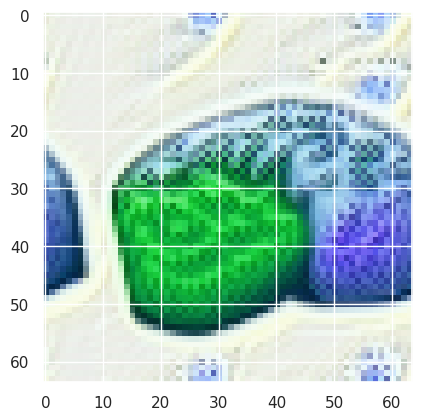

In [9]:
plt.imshow(vid[-1].cpu().numpy())

In [18]:
len(cfgs)

40

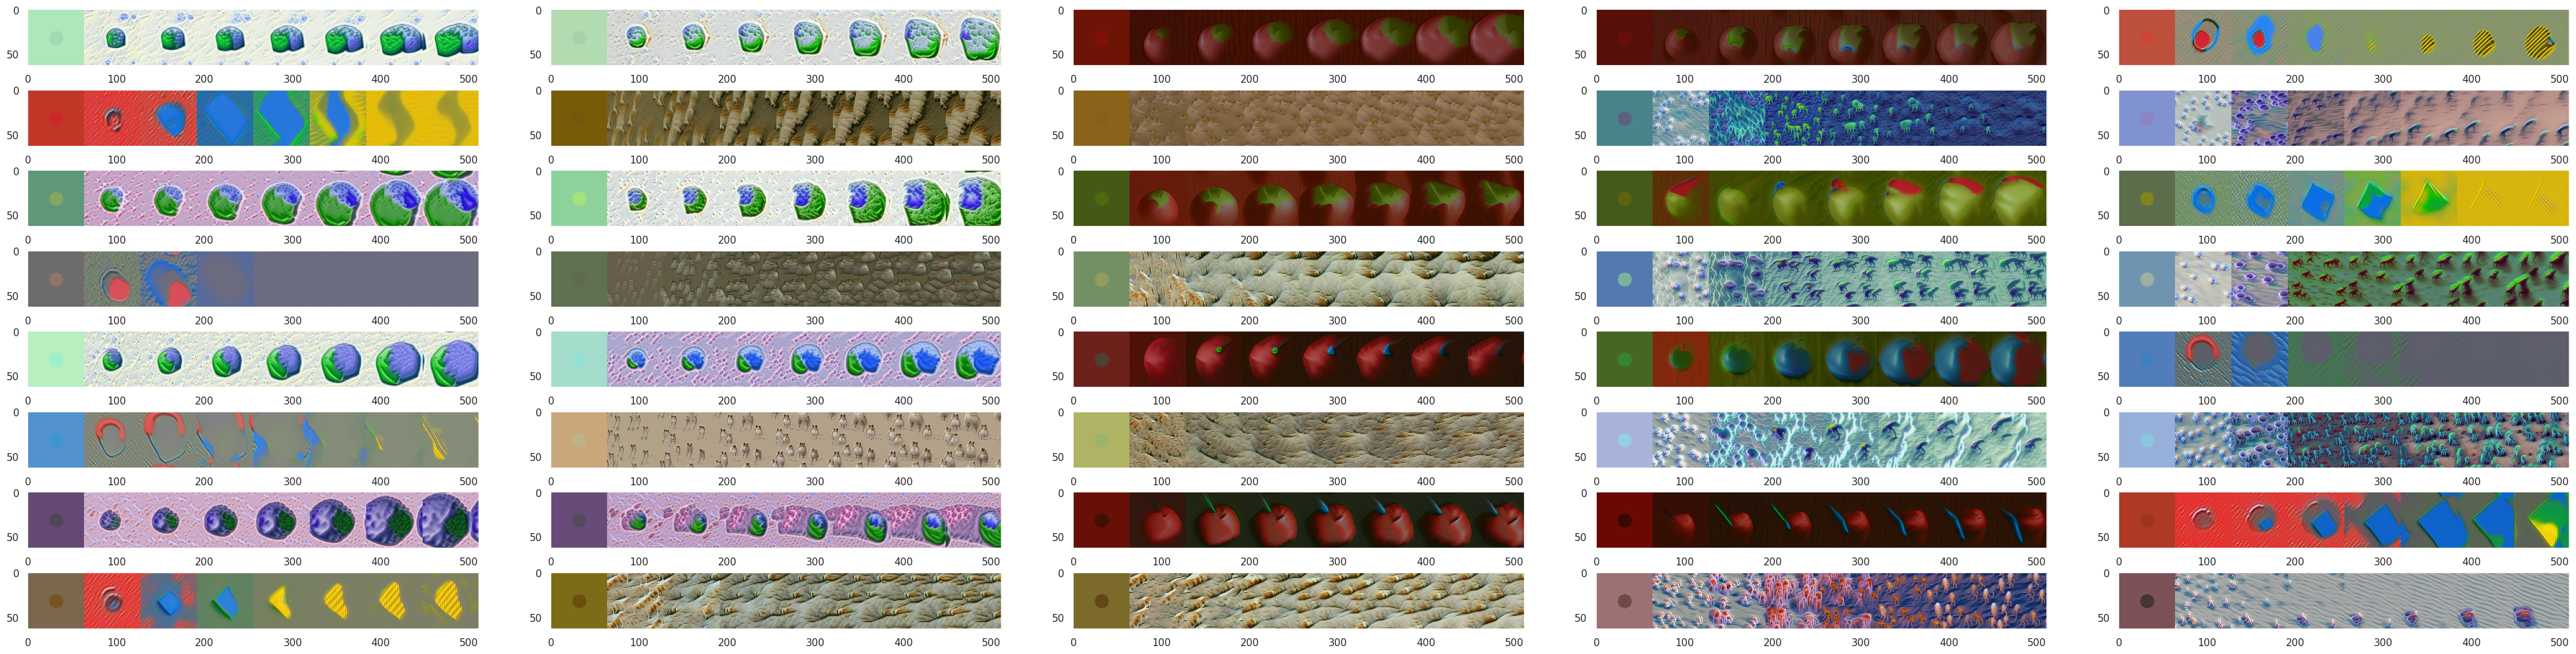

In [61]:
plt.figure(figsize=(40, 10))
iplt = 0
for cfg in cfgs:
    save_dir = cfg['save_dir']
    vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
    iplt += 1
    plt.subplot(8, 5, iplt)
    img = rearrange(vid[::len(vid)//8], "T H W D -> H (T W) D")
    plt.imshow(img)
    plt.grid(False)
    # plt.title(f"{prompts}\n{coef_temporal_softmax=}")
plt.tight_layout()
plt.show()

In [10]:
plt.figure(figsize=(40, 20))
iplt = 0
for coef_temporal_softmax in tqdm(coef_temporal_softmax_sweep):
    for i1, prompts in enumerate(prompts_sweep):
        vid = []
        for seed in seeds:
            save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_1/{seed}_{i1}_{coef_temporal_softmax}"
            vid.append(util.load_pkl(save_dir, "vid").astype(np.uint8))
        vid = np.stack(vid)

        iplt += 1
        plt.subplot(5, 4, iplt)
        plt.imshow(rearrange(vid[:, ::vid.shape[1]//8], "R C H W D -> (R H) (C W) D"))
        plt.grid(False)
        plt.title(f"{prompts}\n{coef_temporal_softmax=}")
plt.tight_layout()
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_1/1_0_0.03/vid.pkl'

<Figure size 4000x2000 with 0 Axes>

In [23]:
cfg = cfgs[0]
save_dir = cfg['save_dir']

In [24]:
from models.models_torch import NCA, sample_init_state
nca = NCA(d_state=cfg['d_state'], perception=cfg['perception'], kernel_size=cfg['kernel_size'], padding_mode=cfg['padding_mode'],
                d_embds=[48, 128], cell_norm=False, state_unit_norm=True, dt=cfg['dt'], dropout=cfg['dropout']).to('cuda').to(torch.float32)
nca.load_state_dict(torch.load(f"{save_dir}/nca.pt"))

/var/tmp/ipykernel_3091366/4244751549.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nca.load_state_dict(torch.load(f"{save_dir}/nca.pt"))


<All keys matched successfully>

In [57]:
torch.manual_seed(0)
# state = sample_init_state(cfg['img_size'], cfg['img_size'], cfg['d_state'], cfg['bs'], cfg['init_state'], state_unit_norm=True, device='cuda', dtype=torch.float32)
state = sample_init_state(64, 64, cfg['d_state'], cfg['bs'], 'circle_rand', state_unit_norm=True, device='cuda', dtype=torch.float32)
state = repeat(state, "B D H W -> B D (1 H) (1 W)")
vid = []
for _ in tqdm(range(256)):
    with torch.no_grad():
        state, obs = nca.forward_step(state)
    vid.append(obs)
vid = rearrange(torch.stack(vid), "T B D H W -> B T H W D").sigmoid()

100%|██████████| 256/256 [00:00<00:00, 4300.47it/s]


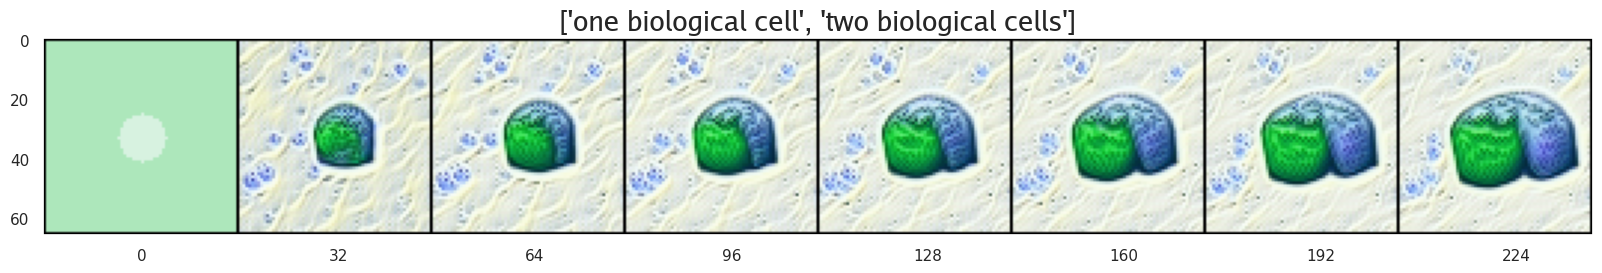

In [58]:
plt.figure(figsize=(20, 10))
img = vid[0, ::32].cpu().numpy()
img = np.pad(img, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant', constant_values=0.)
img = rearrange(img, "T H W D -> (H) (T W) D")
img = np.pad(img, ((1, 0), (1, 0), (0, 0)), mode='constant', constant_values=0.)
plt.imshow(img)
plt.grid(False)
plt.xticks(np.arange(33, 66*8, 66), [f"{i}" for i in np.arange(0, 256, 32)])
# plt.yticks([])

prompts = cfg['prompts'].split(',')
plt.title(prompts, fontsize=20, fontname='Go')

plt.show()

In [501]:
def wrap_str(s, n):
    words = s.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + len(current_line) > n:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word)

    if current_line:
        lines.append(' '.join(current_line))

    return '\n'.join(lines)

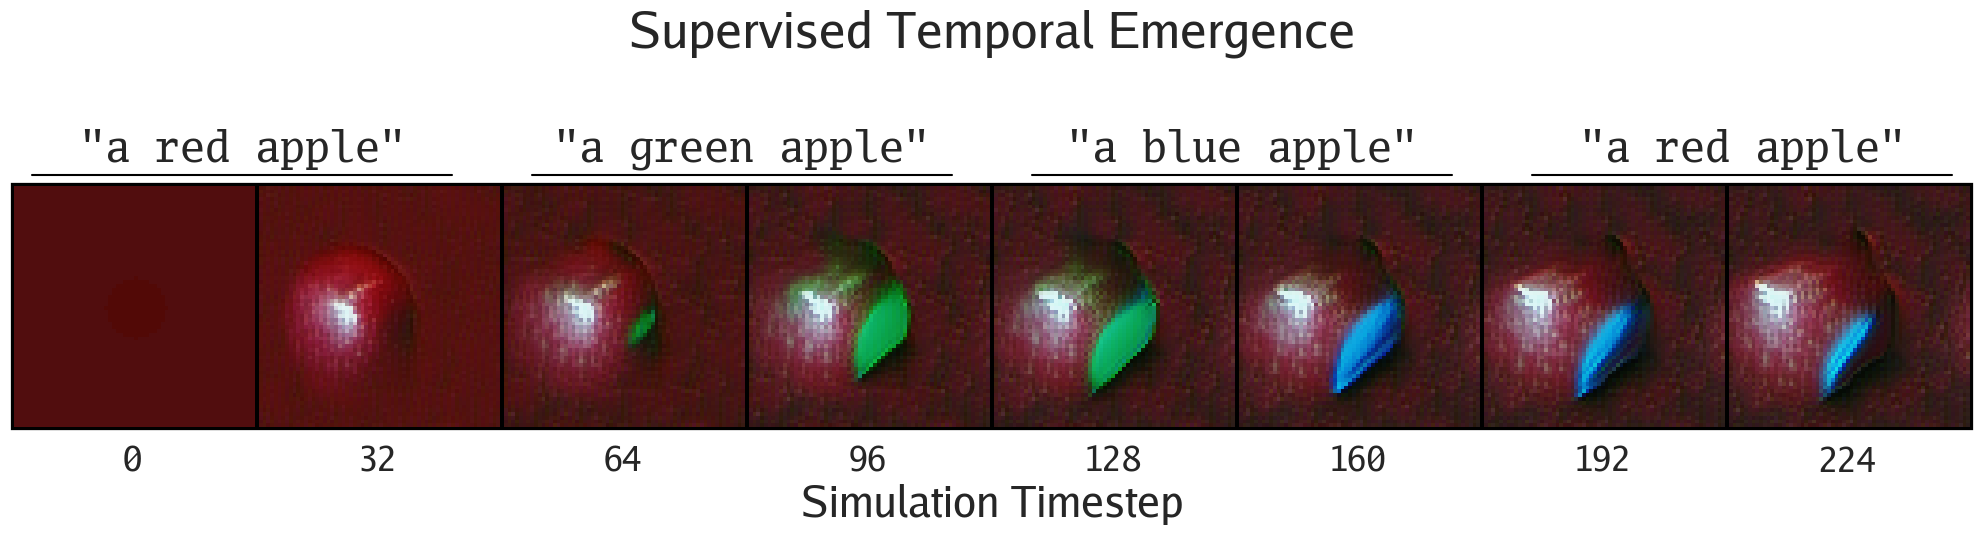

In [502]:
fig = plt.figure(figsize=(20, 5.5))
img = vid[0, ::32].cpu().numpy()
img = np.pad(img, ((0, 0), (0, 1), (0, 1), (0, 0)), mode='constant', constant_values=0.)
img = rearrange(img, "T H W D -> (H) (T W) D")
img = np.pad(img, ((1, 0), (1, 0), (0, 0)), mode='constant', constant_values=0.)
plt.imshow(img)
plt.grid(False)
plt.xticks(np.arange(32, 65*8, 65), [f"{i}" for i in np.arange(0, 256, 32)], fontsize=25, fontname='Go')
plt.yticks([])
plt.xlabel("Simulation Timestep", fontsize=30, fontname='Go')

prompts = cfg['prompts'].split(',')
import matplotlib.lines as lines
for i, prompt in enumerate(prompts):
    prompt = wrap_str(prompt, 20)
    # fig.text(i*0.5+0.25, 0.8, f"\"{prompt}\"", fontsize=30, fontname='Go Mono', ha='center', va='center')
    fig.text(i*1./len(prompts)+1./len(prompts)/2., 0.69, f"\"{prompt}\"", fontsize=30, fontname='Go Mono', ha='center', va='bottom')
    a = (i)/len(prompts)
    b = (i+1)/len(prompts)
    fig.add_artist(lines.Line2D([a+0.02, b-0.02], [.68]*2, color='black'))

plt.suptitle(f"Supervised Temporal Emergence", fontsize=35, fontname='Go')
plt.tight_layout()

plt.savefig(f"/home/akarsh_sakana_ai/nca-alife-data/nca_temporal_4.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [410]:
import copy
df = []
for cfg in cfgs:
    save_dir = cfg['save_dir']
    data = util.load_pkl(save_dir, 'data')
    dfi = copy.copy(cfg)

    data = util.load_pkl(save_dir, 'data')
    for k in ['loss_alignment', 'loss_temporal_softmax', 'loss_temporal_novelty']:
        dfi[k] = data[k][-200:].mean().item()
        dfi[F"{k}_init"] = data[k][:200].mean().item()
    
    df.append(dfi)
df = pd.DataFrame(df)

<Axes: xlabel='loss_alignment', ylabel='loss_temporal_softmax'>

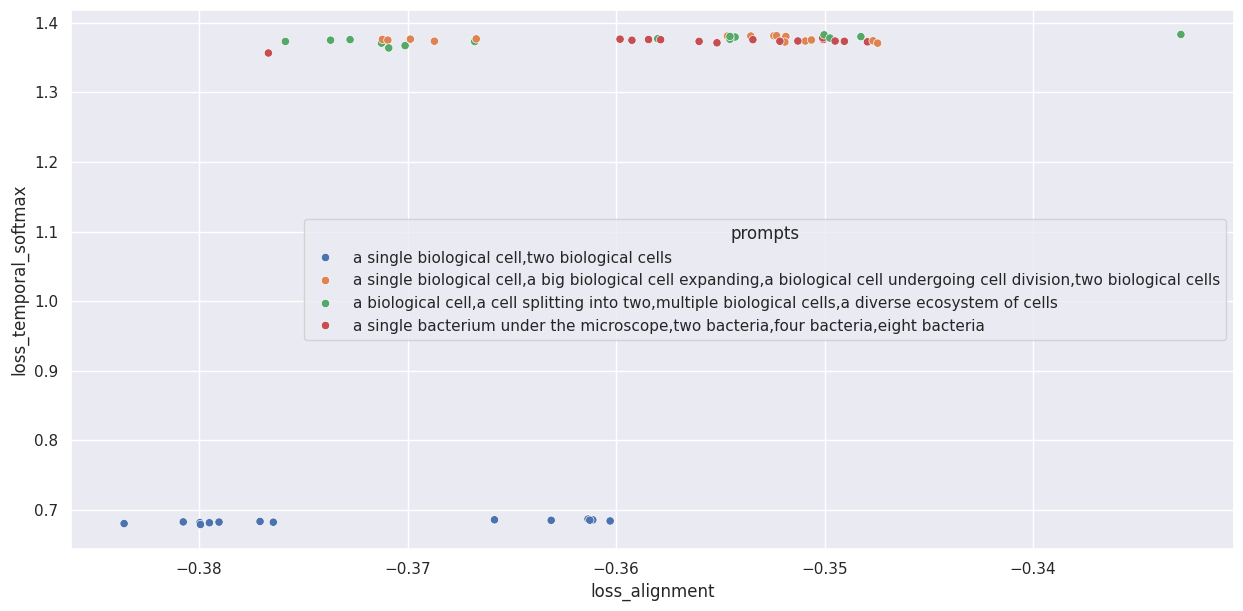

In [418]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df, x='loss_alignment', y='loss_temporal_softmax', hue='prompts')

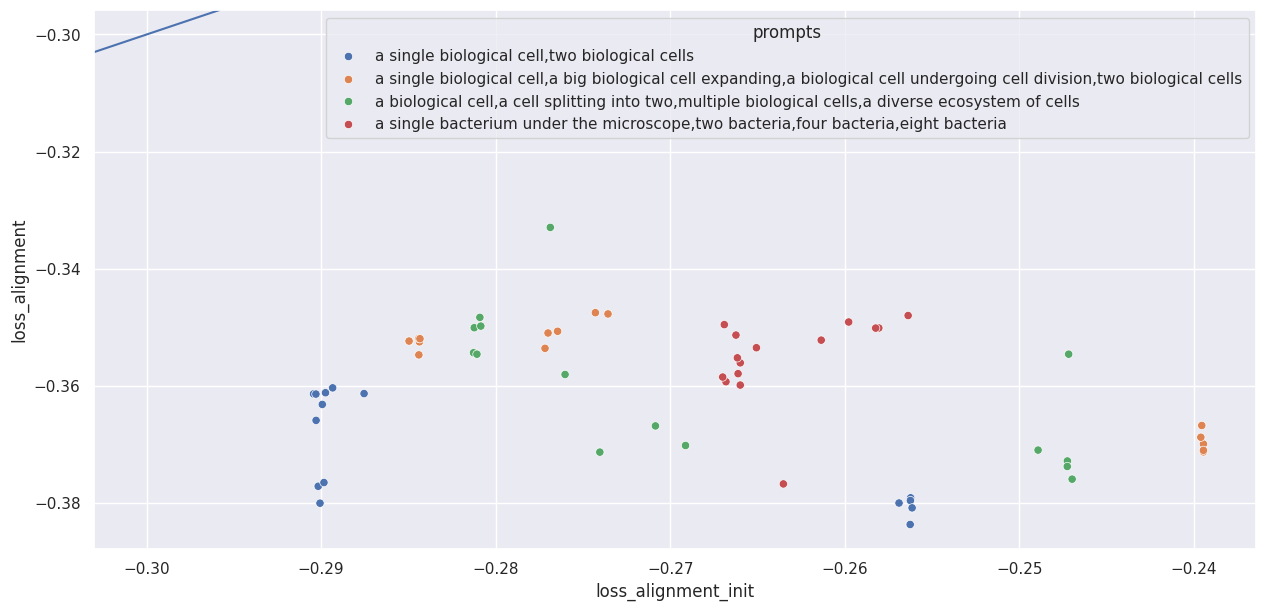

In [427]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df, x='loss_alignment_init', y='loss_alignment', hue='prompts')
plt.axline((-.3, -.3), slope=1)
